In [20]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
#%matplotlib inline

In [17]:
## Cell to calibrate camera
def CalibrateCamera():
    
    #Image Shape
    nx=9
    ny=6
    # Define object points
    objp = np.zeros((nx*ny,3), np.float32)
    #Re-shape to generate correct grid indices.
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    #Create arrays to hold objectpoints, imgpoints
    obj_points = [] #Object points array
    img_points = [] #Image points array
    
    #Define subplots that will be used to draw upto 20 chessboard images
    plt.close('all') # Close all exiting plots
    nCol = 4 # 4 images per row
    nRow = 5  # Need 5 rows for all chessboard images ( not all images will be used )
    #https://matplotlib.org/examples/pylab_examples/subplots_demo.html
    figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
    axis = axis.reshape(-1)
    #Have to get rid of rest of all the boundary axis
    for i in range((nCol*nRow)):
        axis[i].axis('off')
    
    images = glob.glob('camera_cal/calibration*.jpg')
    
    #Step through images to generate imgpoints
    for idx,fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if( ret == True):
            img_draw=[]
            obj_points.append(objp)
            img_points.append(corners)
            #Draw the images with chessboard corners - Not all will be shown as all won't be useful
            img_draw = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            axis[idx].imshow(img_draw)
        
    #Calculate the camera matrix, distortion coeffecients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        
    return mtx, dist
    

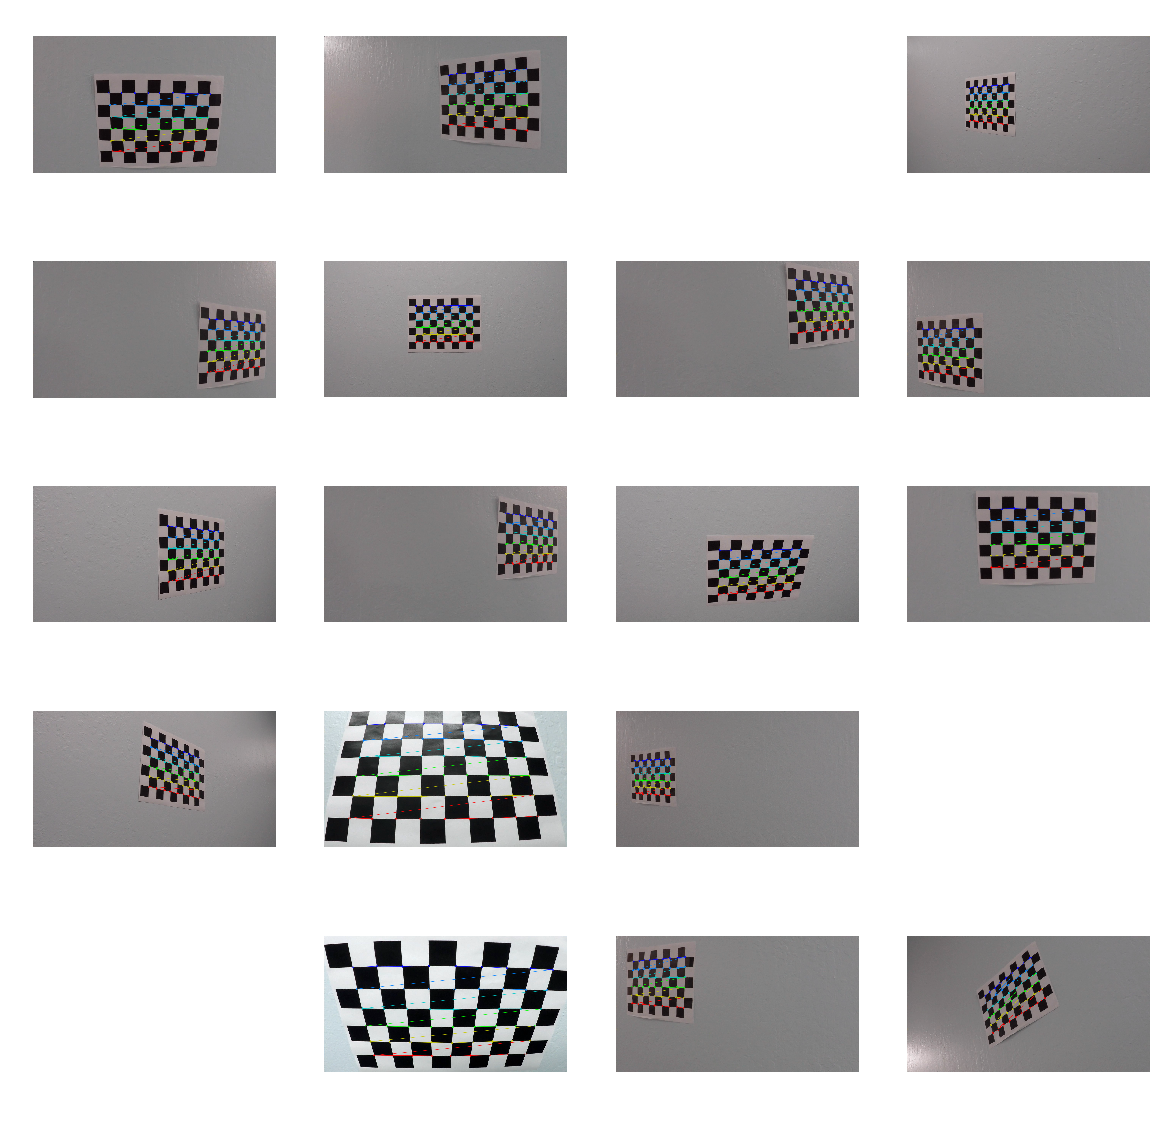

In [18]:
## Cell to call calibrate and save calibration data to a pickled file
mtx, dist = CalibrateCamera()

calibration_data = {} # Dictionary
calibration_data["mtx"] = mtx
calibration_data["dist"] = dist
pickle.dump(calibration_data, open("calibration.p","wb"))

In [3]:
## Cell to load camera calibration settings
def loadCalibrationSettings():
    calibration_data = {}
    with open("calibration.p",mode='rb') as f:
        calibration_data = pickle.load(f)
    mtx = calibration_data["mtx"]
    dist = calibration_data["dist"]
    return mtx,dist

In [4]:
def undistortImage(img, mtx, dist):
    image = cv2.undistort(img, mtx, dist, None, mtx)
    return image

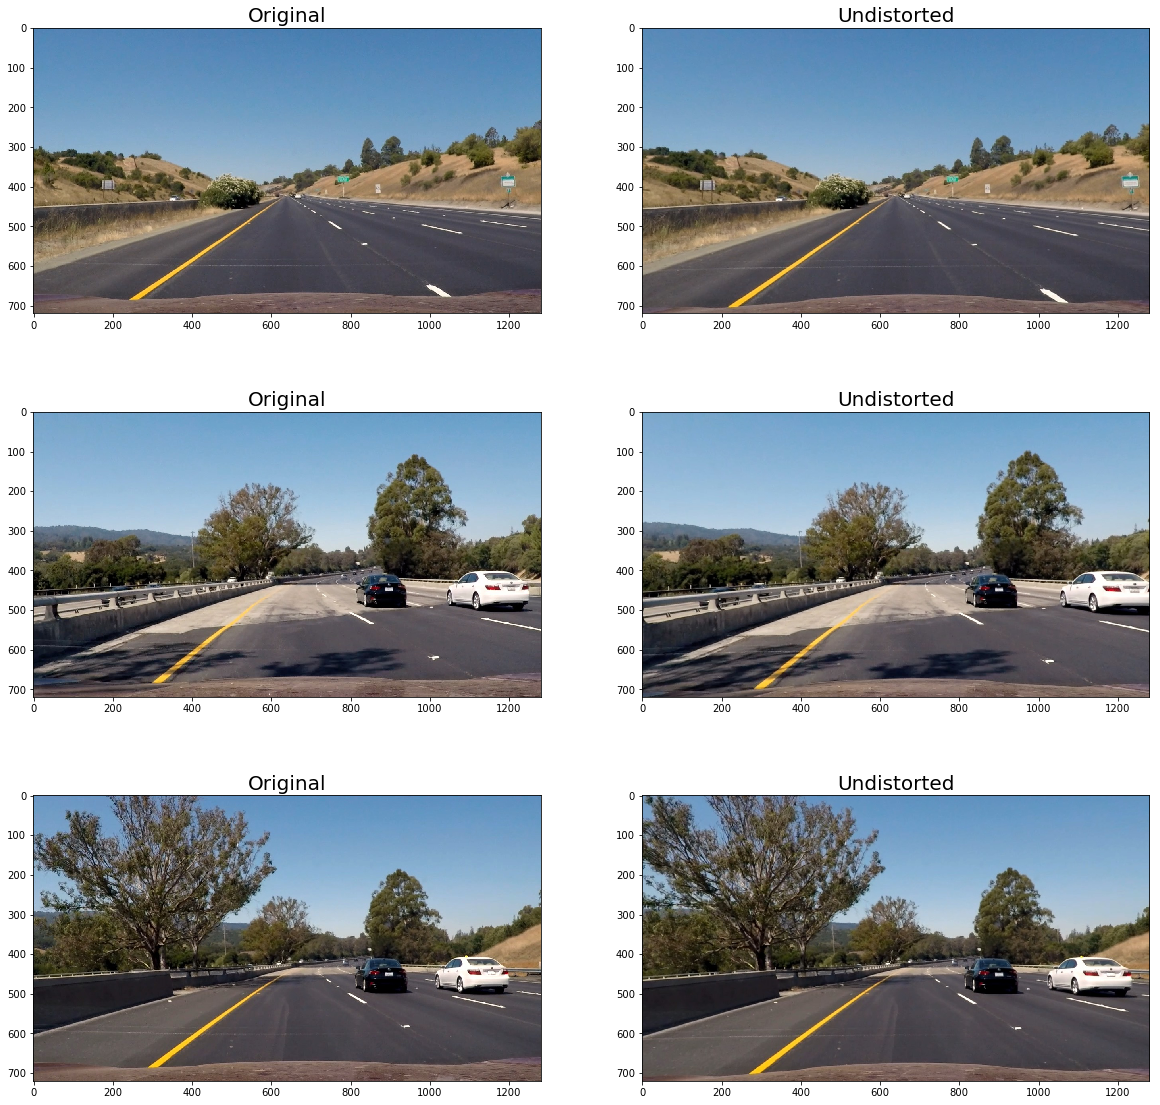

In [21]:
# Sample image undistortion check
ctr=0
plt.close('all')
nCol = 2 # 2 images per row
nRow = 3  # Need 11 rows for 43 classes
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)
#Have to get rid of rest of all the boundary axis
#for i in range((nCol*nRow)):
#    axis[i].axis('off')
mtx, dist = loadCalibrationSettings()

#First sample set
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)
axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(image)
ctr +=1
axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(img)
ctr +=1
mpimg.imsave('output_images/straight_lines1_undistorted', img)

#Second sample set
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)
axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(image)
ctr +=1
axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(img)
ctr+=1
mpimg.imsave('output_images/test4_undistorted', img)

#Second sample set
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)
axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(image)
ctr +=1
axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(img)
ctr+=1
mpimg.imsave('output_images/test6_undistorted', img)

In [33]:
## Cell for perspective transformation
def perspTransform(img, src, dst, imgSize):
    #Map points between undistorted and top-down perspective
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, imgSize, flags=cv2.INTER_LINEAR)
    return warped

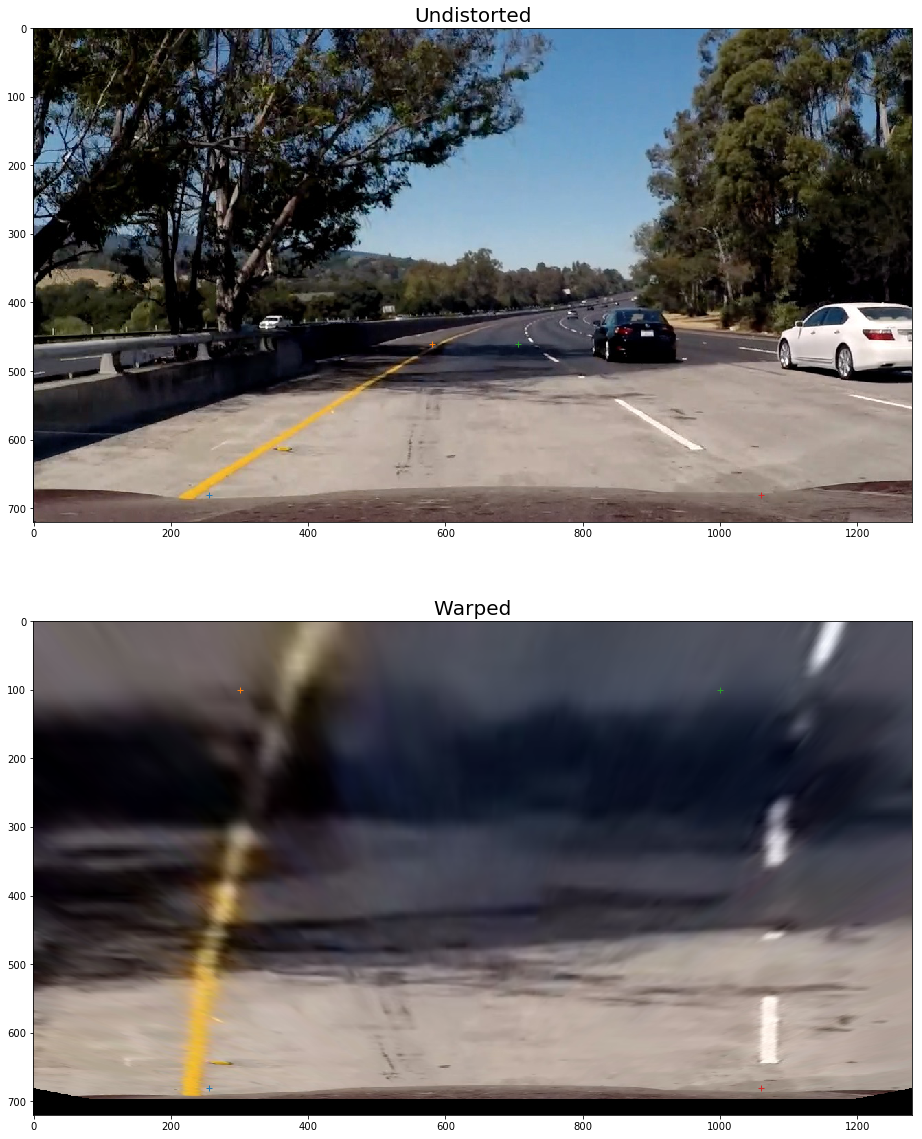

In [282]:
#Test for perspective transformation
ctr=0
plt.close('all')
nCol = 1 # 2 images per row
nRow = 2 # Need 1 row to display 2 images
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)

mtx, dist = loadCalibrationSettings()
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

#Finalized image sizes after testing
src = np.float32( [ [255, 680],
                    [580, 460],
                    [705, 460],
                    [1060, 680] ]
                )

dst = np.float32( [ [255, 680],
                    [300, 100],
                    [1000, 100],
                    [1060, 680] ]
                )
imgSize = (img.shape[1], img.shape[0])

warped_img = perspTransform(img, src, dst, imgSize)

axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(image)
axis[ctr].plot(255, 680, "+")
axis[ctr].plot(580, 460, "+")
axis[ctr].plot(705, 460, "+")
axis[ctr].plot(1060, 680, "+")
ctr +=1

axis[ctr].set_title('Warped', fontsize=20)
axis[ctr].imshow(warped_img)
axis[ctr].plot(255, 680, "+")
axis[ctr].plot(300, 100, "+")
axis[ctr].plot(1000, 100, "+")
axis[ctr].plot(1060, 680, "+")
ctr +=1


In [65]:
## Threshold functions cell
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if ( orient == 'x' ):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    
    # Apply threshold
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])]=1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Apply threshold
    # Rescale to 8 bit
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag)) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

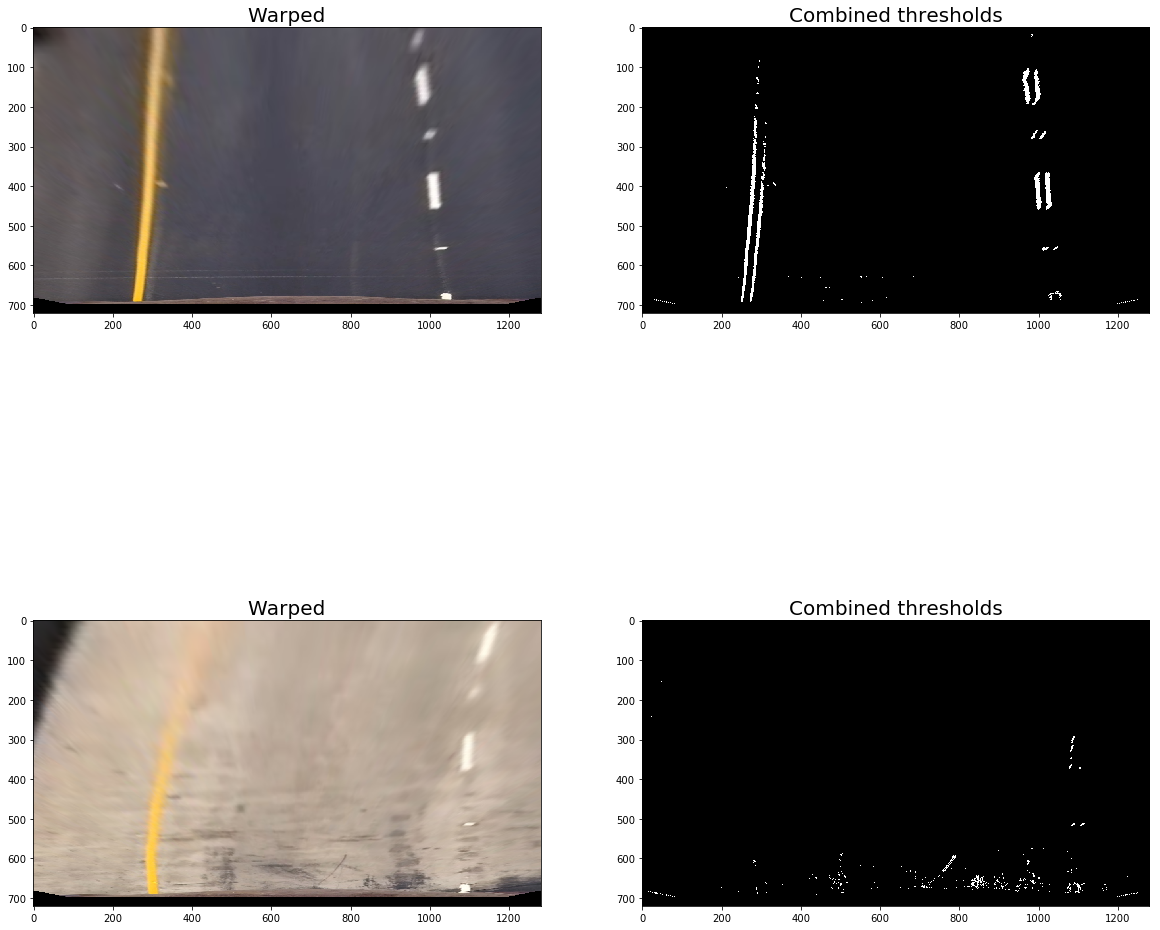

In [284]:
#Test for thresholding
ctr=0
plt.close('all')
nCol = 2 # 2 images per row
nRow = 2 # Need 1 row to display 2 images
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)

#Finalized image sizes
src = np.float32( [ [255, 680],
                    [580, 460],
                    [705, 460],
                    [1060, 680] ]
                )

dst = np.float32( [ [255, 680],
                    [300, 100],
                    [1000, 100],
                    [1060, 680] ]
                )
imgSize = (img.shape[1], img.shape[0])
mtx, dist = loadCalibrationSettings()

#imageset 1
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

warped_img = perspTransform(img, src, dst, imgSize)

axis[ctr].set_title('Warped', fontsize=20)
axis[ctr].imshow(warped_img, cmap='gray')
ctr +=1

grad_x     = abs_sobel_thresh(warped_img, orient='x', sobel_kernel=3, thresh=(30, 180))
grad_y     = abs_sobel_thresh(warped_img, orient='y', sobel_kernel=3, thresh=(30, 100))
mag_binary = mag_thresh(warped_img, sobel_kernel=3, mag_thresh=(30, 180))
dir_binary = dir_threshold(warped_img, sobel_kernel=3, thresh=(0.3, 1.3))

combined = np.zeros_like(mag_binary)
combined[(grad_x == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
axis[ctr].set_title('Combined thresholds', fontsize=20)
axis[ctr].imshow(combined, cmap='gray')
ctr +=1

#imageset 2
image_2 = cv2.imread('test_images/test1.jpg')
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
img_2 = undistortImage(image_2, mtx, dist)

warped_img_2 = perspTransform(img_2, src, dst, imgSize)

axis[ctr].set_title('Warped', fontsize=20)
axis[ctr].imshow(warped_img_2, cmap='gray')
ctr +=1

grad_x_2     = abs_sobel_thresh(warped_img_2, orient='x', sobel_kernel=3, thresh=(30, 150))
grad_y_2     = abs_sobel_thresh(warped_img_2, orient='y', sobel_kernel=3, thresh=(30, 100))
mag_binary_2 = mag_thresh(warped_img_2, sobel_kernel=3, mag_thresh=(30, 180))
dir_binary_2 = dir_threshold(warped_img_2, sobel_kernel=3, thresh=(0.3, 1.3))

combined_2 = np.zeros_like(mag_binary_2)
combined_2[(mag_binary_2 == 1)] = 1
axis[ctr].set_title('Combined thresholds', fontsize=20)
axis[ctr].imshow(grad_x_2, cmap='gray')
ctr +=1

##In above tests it was seen that grad_y is useless. Other than that the values were modified to get best lane detection

In [122]:
## Cell for color spaces separation

def getRGBLanes(img, color='R', thresh=(0,255)):
    if( color == 'R'):
        image = img[:,:,0]
    if( color == 'G'):
        image = img[:,:,1]
    if( color == 'B'):
        image = img[:,:,2]
    
    #Apply thresholds
    binary = np.zeros_like(image)
    binary[(image > thresh[0]) & (image < thresh[1])] = 1
    return binary

def getHLSLanes(img, color='S', thresh=(0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if( color == 'H'):
        image = img[:,:,0]
    if( color == 'L'):
        image = img[:,:,1]
    if( color == 'S'):
        image = img[:,:,2]
    
    #Apply thresholds
    binary = np.zeros_like(image)
    binary[(image > thresh[0]) & (image <= thresh[1])] = 1 #manbir for S try opposite logic
    return binary

"\nctr+=1 #Ignore one space as we have only 7 images as against 8 subplots\n#imageset 2\nimage = cv2.imread('test_images/test5.jpg')\nimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\nimg = undistortImage(image, mtx, dist)\n\nimg_r = getRGBLanes(img, color='R', thresh=(30,130))\nimg_g = getRGBLanes(img, color='G', thresh=(30,130))\nimg_b = getRGBLanes(img, color='B', thresh=(30,130))\n\nimg_h = getHLSLanes(img, color='H', thresh=(30,130))\nimg_l = getHLSLanes(img, color='L', thresh=(30,130))\nimg_s = getHLSLanes(img, color='S', thresh=(30,130))\n\naxis[ctr].set_title('Original', fontsize=20)\naxis[ctr].imshow(img)\nctr +=1\naxis[ctr].set_title('Red', fontsize=20)\naxis[ctr].imshow(img_r, cmap='gray')\nctr +=1\naxis[ctr].set_title('Green', fontsize=20)\naxis[ctr].imshow(img_g, cmap='gray')\nctr +=1\naxis[ctr].set_title('Blue', fontsize=20)\naxis[ctr].imshow(img_b, cmap='gray')\nctr +=1\naxis[ctr].set_title('Hue', fontsize=20)\naxis[ctr].imshow(img_h, cmap='gray')\nctr +=1\naxis[ctr].set_t

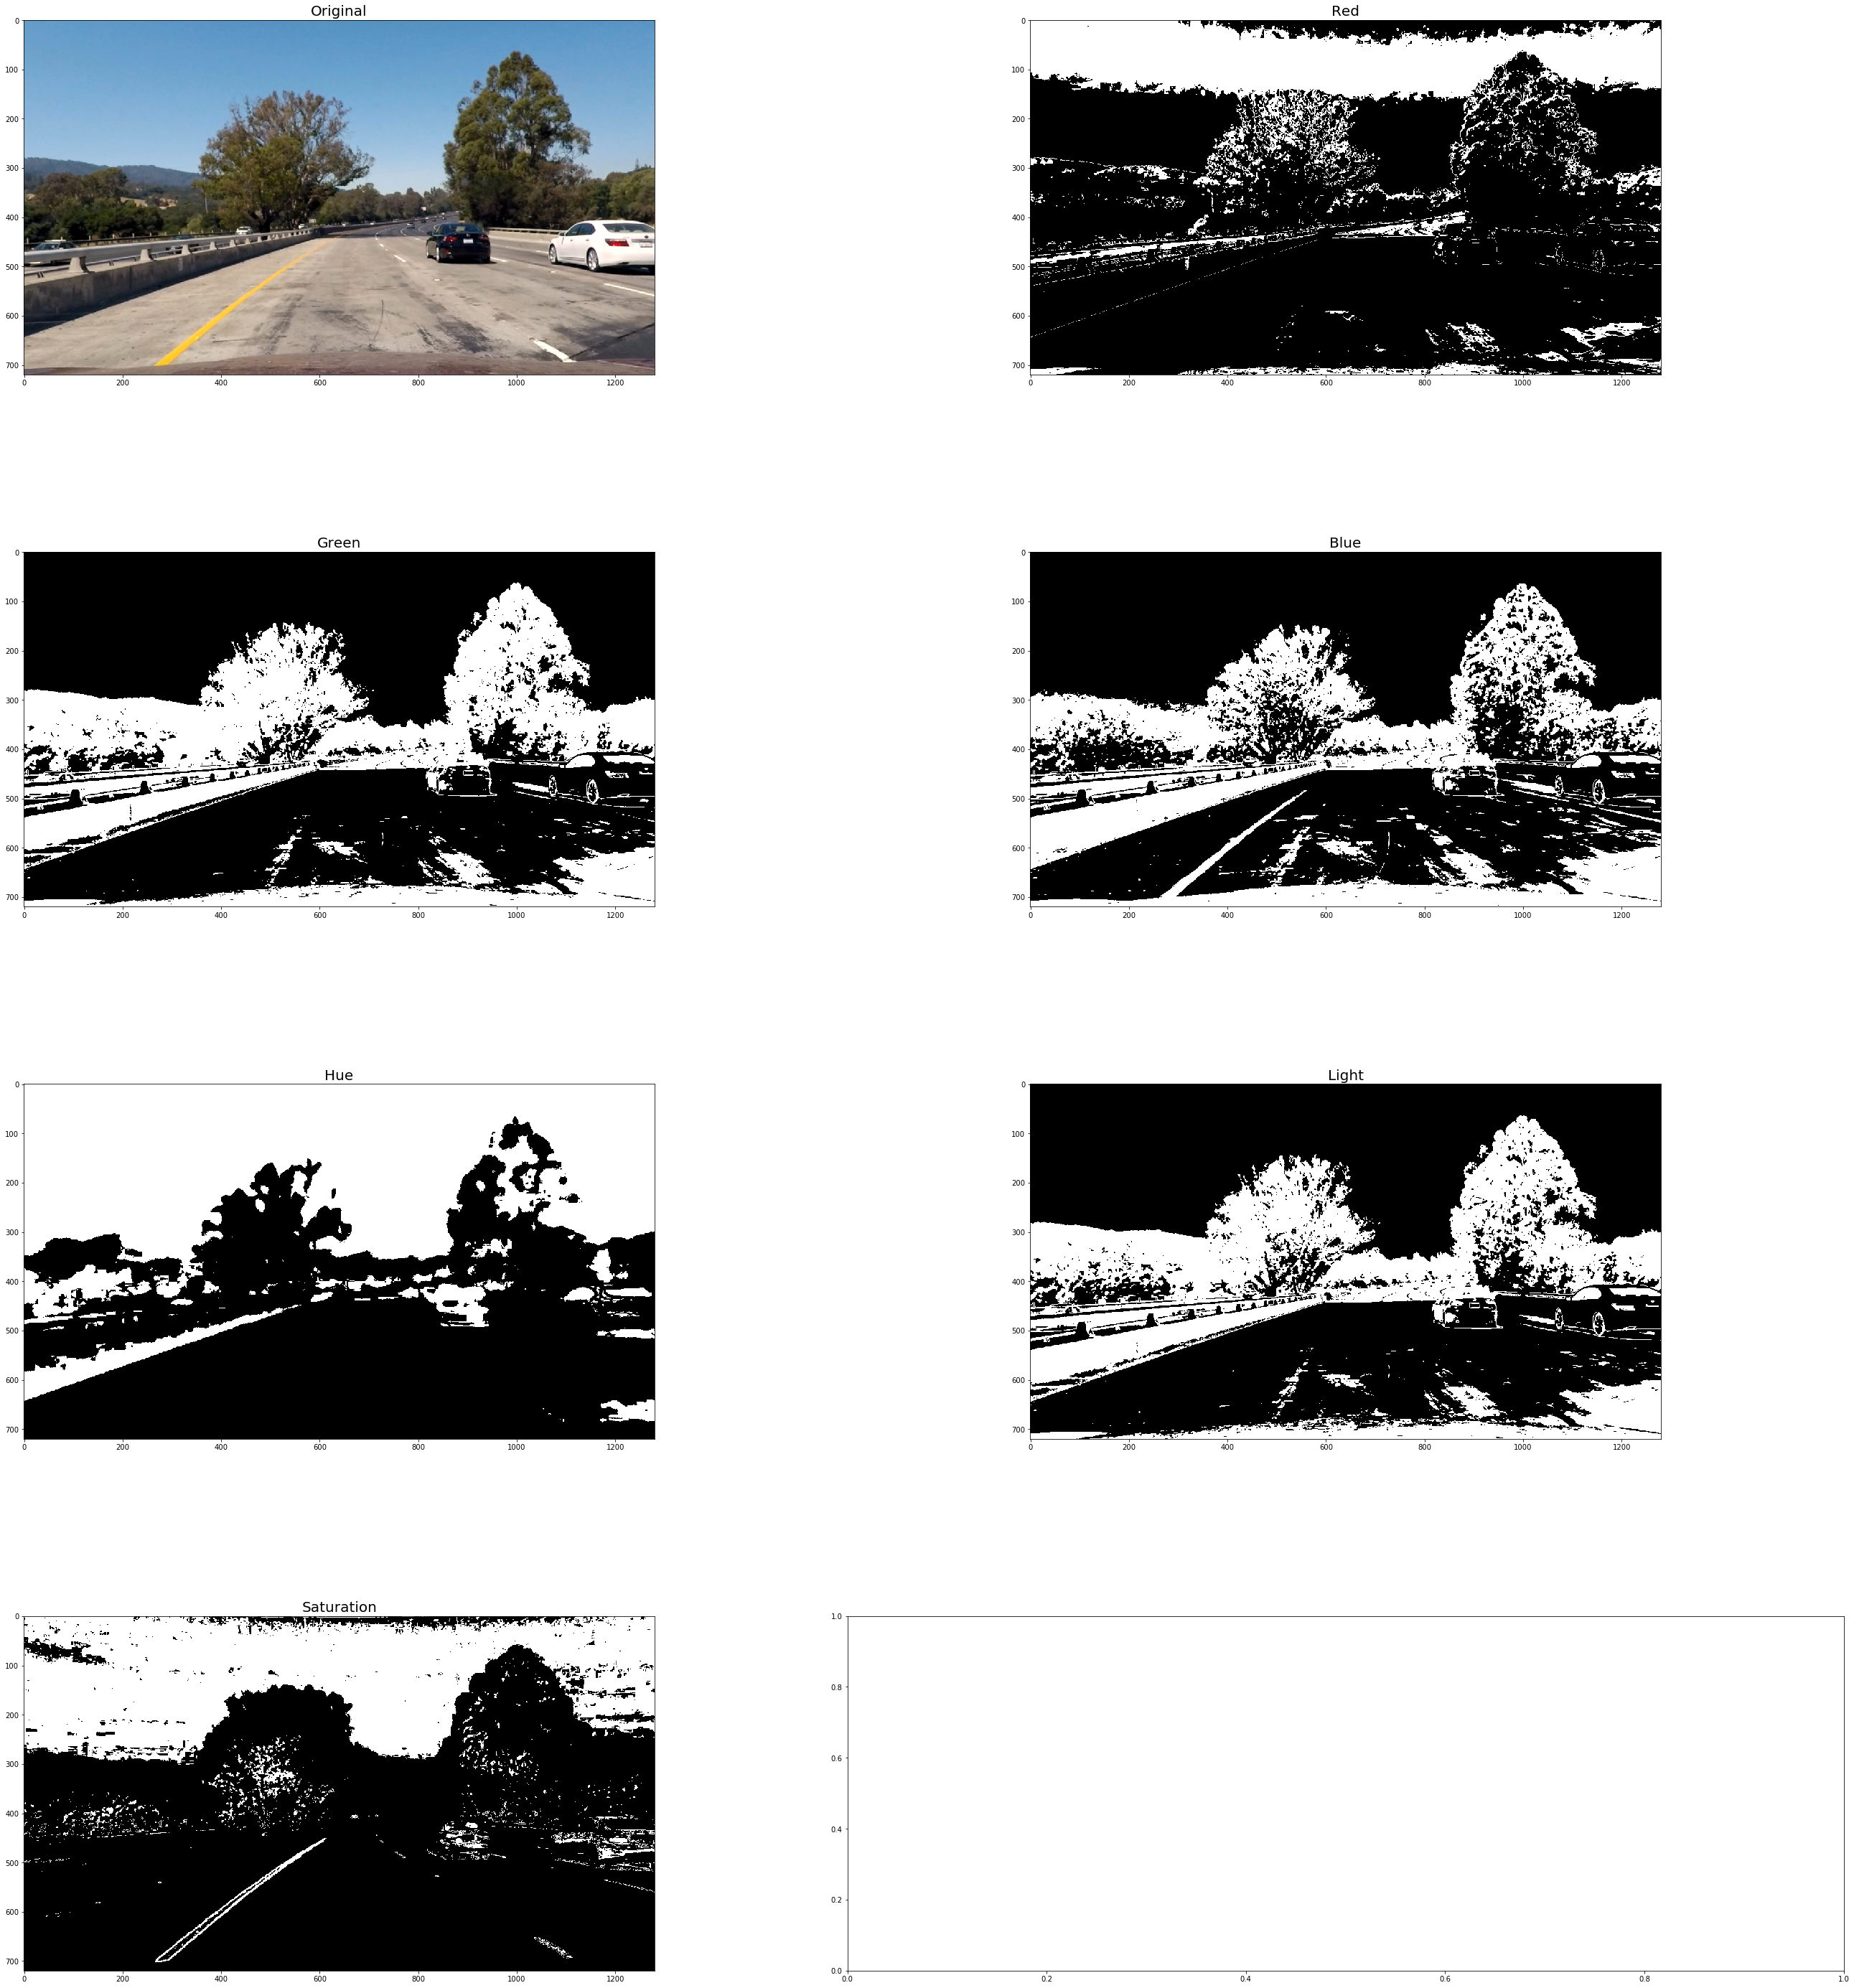

In [290]:
## Test for RGB and HLS image binarization
ctr=0
plt.close('all')
nCol = 2 # 2 images per row
nRow = 4 # Need 8 row to display 2 image sets(RGB, HLS)
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(50,50))
figure.subplots_adjust(hspace = 0.5, wspace=.01)
axis = axis.reshape(-1)

mtx, dist = loadCalibrationSettings()

#imageset 1
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

img_r = getRGBLanes(img, color='R', thresh=(90,120))
img_g = getRGBLanes(img, color='G', thresh=(30,130))
img_b = getRGBLanes(img, color='B', thresh=(30,130))

img_h = getHLSLanes(img, color='H', thresh=(30,130))
img_l = getHLSLanes(img, color='L', thresh=(30,130))
img_s = getHLSLanes(img, color='S', thresh=(120,250))

axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(img)
ctr +=1
axis[ctr].set_title('Red', fontsize=20)
axis[ctr].imshow(img_r, cmap='gray')
ctr +=1
axis[ctr].set_title('Green', fontsize=20)
axis[ctr].imshow(img_g, cmap='gray')
ctr +=1
axis[ctr].set_title('Blue', fontsize=20)
axis[ctr].imshow(img_b, cmap='gray')
ctr +=1
axis[ctr].set_title('Hue', fontsize=20)
axis[ctr].imshow(img_h, cmap='gray')
ctr +=1
axis[ctr].set_title('Light', fontsize=20)
axis[ctr].imshow(img_l, cmap='gray')
ctr +=1
axis[ctr].set_title('Saturation', fontsize=20)
axis[ctr].imshow(img_s, cmap='gray')
ctr +=1

'''
ctr+=1 #Ignore one space as we have only 7 images as against 8 subplots
#imageset 2
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

img_r = getRGBLanes(img, color='R', thresh=(30,130))
img_g = getRGBLanes(img, color='G', thresh=(30,130))
img_b = getRGBLanes(img, color='B', thresh=(30,130))

img_h = getHLSLanes(img, color='H', thresh=(30,130))
img_l = getHLSLanes(img, color='L', thresh=(30,130))
img_s = getHLSLanes(img, color='S', thresh=(30,130))

axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(img)
ctr +=1
axis[ctr].set_title('Red', fontsize=20)
axis[ctr].imshow(img_r, cmap='gray')
ctr +=1
axis[ctr].set_title('Green', fontsize=20)
axis[ctr].imshow(img_g, cmap='gray')
ctr +=1
axis[ctr].set_title('Blue', fontsize=20)
axis[ctr].imshow(img_b, cmap='gray')
ctr +=1
axis[ctr].set_title('Hue', fontsize=20)
axis[ctr].imshow(img_h, cmap='gray')
ctr +=1
axis[ctr].set_title('Light', fontsize=20)
axis[ctr].imshow(img_l, cmap='gray')
ctr +=1
axis[ctr].set_title('Saturation', fontsize=20)
axis[ctr].imshow(img_s, cmap='gray')
ctr +=1

#Result: Red and S work best'''

In [291]:
## Cell for combined visualization of R and S from RGB, HLS space and gradient thresholds
def ProcessImage(img, verbose=False):
    #First do grad_x, magnitude and direction for sobel thresholds
    grad_x     = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 180))
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 180))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0.3, 1.3))

    #Do a combined thresholds image
    combined_thresh = np.zeros_like(mag_binary)
    combined_thresh[(grad_x == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #Get R from RGB and S from HLS colorspaces
    img_r = getRGBLanes(img, color='R', thresh=(90,120))
    img_s = getHLSLanes(img, color='S', thresh=(120,250))
    
    #Create a combined RS Image
    combined_color = np.zeros_like(img_r)
    combined_color[(img_r==1) | (img_s==1)]=1
    
    #Create a combined binary
    combined_binary = np.zeros_like(combined_color)
    combined_binary[(combined_thresh == 1) | (combined_color == 1)] = 1
  
    #If true display verbose image just to find detection
    if(verbose == True):
        #First create a joined image in color
        color_binary = np.dstack(( np.zeros_like(combined_thresh), combined_thresh, combined_color)) * 255
        
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary)

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        
    #Return combined binary
    return combined_binary

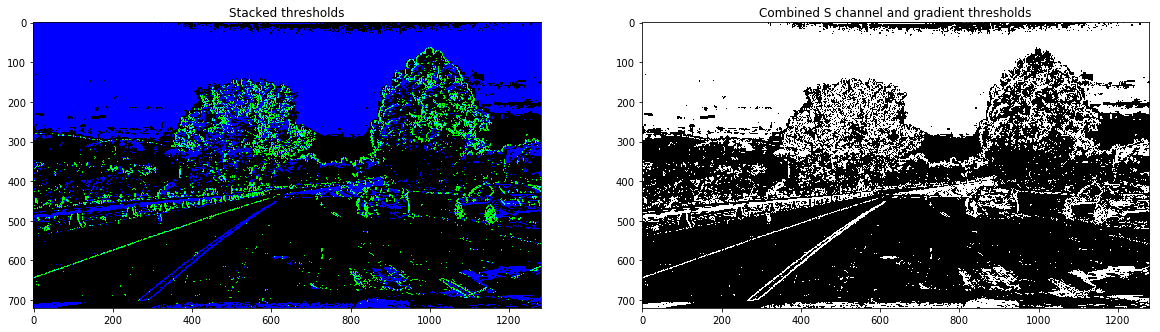

In [292]:
#Test for combined binary
#imageset 1
mtx, dist = loadCalibrationSettings()

#imageset 1
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

combined_binary = ProcessImage(img, True)

In [297]:
## This cell detects lane lines from a warped and thresholded image
def DetectLanePixels(img, return_histogram = False):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    #Create an RGB out of the binary warped
    out_img = np.dstack((img,img,img))*255
    
    #mark maximum of left and right lanes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[300:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle( out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                       (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                       (0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fitx, right_fitx, ploty, out_img
    

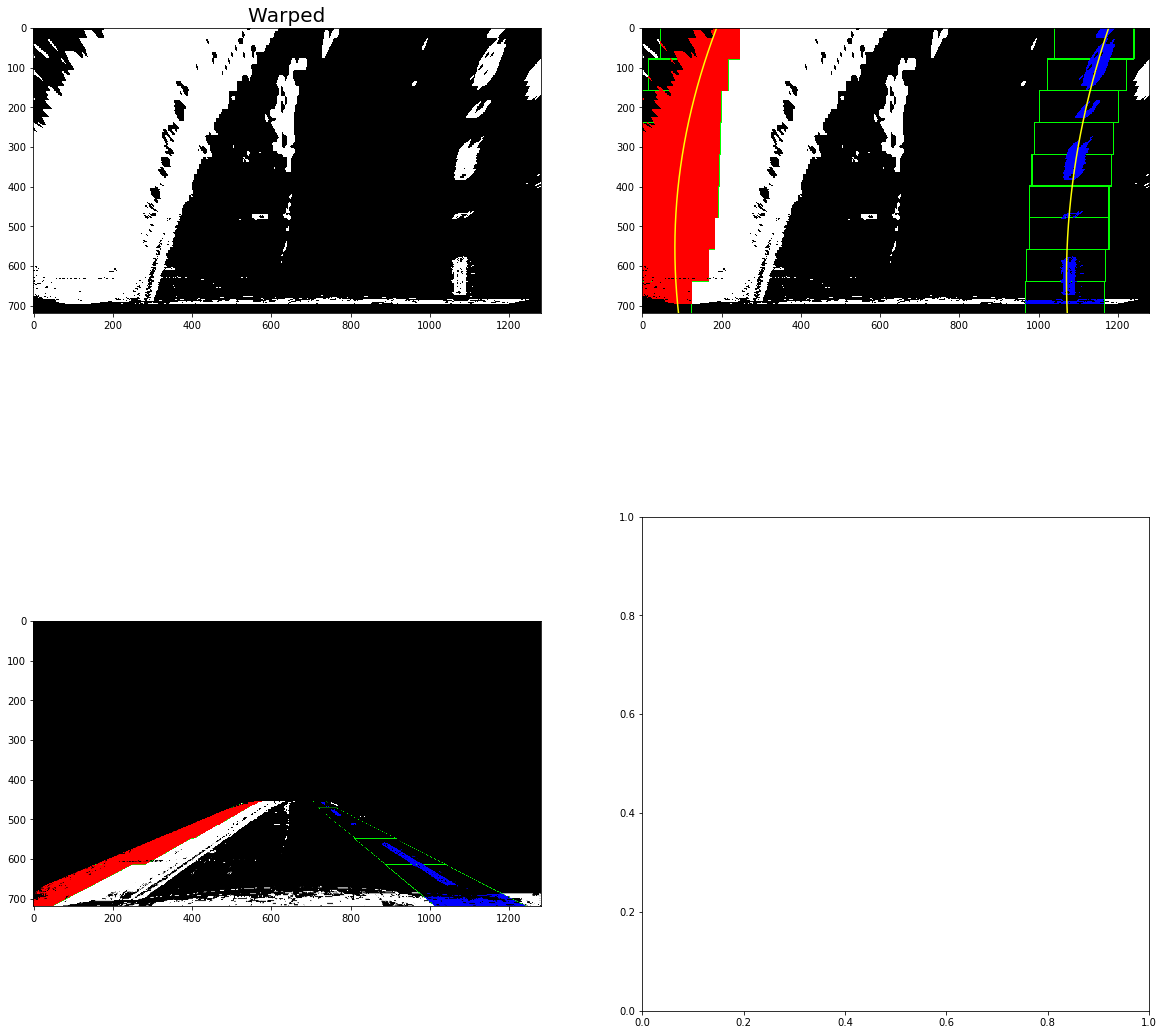

In [298]:
#Test for histogram on combined binary warped image
ctr = 0
plt.close('all')
nCol = 2 # 2 images per row
nRow = 2 # Need 1 row to display 2 images
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)

#imageset 1
mtx, dist = loadCalibrationSettings()

#imageset 1
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

combined_binary = ProcessImage(img, False)
#Finalized image sizes
src = np.float32( [ [255, 680],
                    [580, 460],
                    [705, 460],
                    [1060, 680] ]
                )

dst = np.float32( [ [255, 680],
                    [300, 100],
                    [1000, 100],
                    [1060, 680] ]
                )
imgSize = (combined_binary.shape[1], combined_binary.shape[0])
warped_img = perspTransform(combined_binary, src, dst, imgSize)
axis[ctr].set_title('Warped', fontsize=20)
axis[ctr].imshow(warped_img, cmap='gray')
ctr +=1

left_fitx, right_fitx, ploty, out_img = DetectLanePixels(warped_img)
axis[ctr].imshow(out_img)
axis[ctr].plot(left_fitx, ploty, color='yellow')
axis[ctr].plot(right_fitx, ploty, color='yellow')
#axis[ctr].xlim(0, 1280)
#axis[ctr].ylim(720, 0)
#axis[ctr].plot(histogram)
ctr += 1

#Attempt to see unwarped image
unwarped_img = perspTransform(out_img, dst, src, imgSize)
axis[ctr].imshow(unwarped_img) #Not bad eh!!